### 训练一个分类器

训练流程如下：
1. 采用 `torchvision` 加载和归一化 CIFAR10 训练集和测试集数据；
2. 定义一个卷积神经网络
3. 定义损失函数
4. 在训练集上训练
5. 在测试集上测试模型

#### 1. 加载并归一化 CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
# 将图片数据从 [0,1] 归一化为 [-1, 1] 的取值范围
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


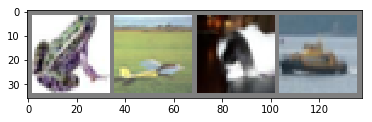

 frog plane   dog  ship


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图片的函数
def imshow(img):
    img = img / 2 + 0.5     # 非归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练集图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片类别标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### 2. 定义一个卷积神经网络

In [25]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#### 3. 定义损失函数

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### 4. 训练网络

In [27]:
import time
start = time.time()
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data
        # 清空梯度缓存
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            # 每 2000 次迭代打印一次信息
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training! Total cost time: ', time.time()-start)

[1,  2000] loss: 2.226
[1,  4000] loss: 1.897
[1,  6000] loss: 1.725
[1,  8000] loss: 1.617
[1, 10000] loss: 1.524
[1, 12000] loss: 1.489
[2,  2000] loss: 1.407
[2,  4000] loss: 1.376
[2,  6000] loss: 1.354
[2,  8000] loss: 1.347
[2, 10000] loss: 1.324
[2, 12000] loss: 1.311
Finished Training! Total cost time:  77.24696755409241


#### 5. 测试模型效果

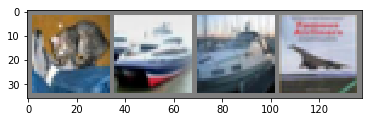

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 打印图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
# 网络输出
outputs = net(images)
print('outputs: ', outputs)
# 预测结果
print('predict: ', torch.max(outputs, 1))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

outputs:  tensor([[-0.2181, -1.9019,  1.3829,  2.5483,  0.0751,  1.8760,  0.0297, -0.6594,
         -0.8500, -1.5192],
        [ 3.7127,  4.8370, -1.3303, -2.4758, -2.9465, -3.5696, -4.0219, -4.0336,
          6.3214,  4.1556],
        [ 1.6718,  1.5673, -0.1557, -0.4965, -1.7998, -1.3584, -1.8403, -1.9009,
          3.5395,  1.7960],
        [ 3.5556,  0.7321,  0.6451, -1.7272, -0.2997, -2.8365, -2.4848, -2.1176,
          4.1163,  0.9163]], grad_fn=<ThAddmmBackward>)
predict:  (tensor([2.5483, 6.3214, 3.5395, 4.1163], grad_fn=<MaxBackward0>), tensor([3, 8, 8, 8]))
Predicted:    cat  ship  ship  ship


对整个测试集进行测试，并计算准确率

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


接下来看看各个类别的准确率

In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 59 %
Accuracy of  bird : 40 %
Accuracy of   cat : 33 %
Accuracy of  deer : 39 %
Accuracy of   dog : 60 %
Accuracy of  frog : 54 %
Accuracy of horse : 66 %
Accuracy of  ship : 70 %
Accuracy of truck : 72 %


#### 在 GPU 上训练

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
import time
# 在 GPU 上训练注意需要将网络和数据放到 GPU 上
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start = time.time()
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 清空梯度缓存
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            # 每 2000 次迭代打印一次信息
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training! Total cost time: ', time.time() - start)

[1,  2000] loss: 1.210
[1,  4000] loss: 1.200
[1,  6000] loss: 1.235
[1,  8000] loss: 1.192
[1, 10000] loss: 1.179
[1, 12000] loss: 1.175
[2,  2000] loss: 1.101
[2,  4000] loss: 1.107
[2,  6000] loss: 1.098
[2,  8000] loss: 1.105
[2, 10000] loss: 1.089
[2, 12000] loss: 1.095
Finished Training! Total cost time:  149.2480025291443
